# Bioacoustic analysis of DAS-recorded data

Author: [Léa Bouffaut](mailto:lb736'cornell.edu)
https://www.birds.cornell.edu/ccb/lea-bouffaut/


Note: a portion of that code to read OOI hdf5 data is derived from the work of Dr. Ethan Williams - more details can be found there - https://gist.github.com/ethanfwilliams/c7c952220ac329db48f8ef159f0b169f
OptaSense QuantX data

### Initialization of the libraries

In [1]:
# Import some other libraries we will use explicitly
import h5py
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import os
import glob
# import time # USed this to time each step

# To keep a log of the work
#import logging 
#logging.config.dictConfig({
#    'version': 1,
#    'disable_existing_loggers': True,
#})
#logging.basicConfig(filename="log.txt", format='%(levelname)s: (asctime)s %(message)s', level=logging.DEBUG)


### Definition of the functions for DAS data conditionning

In [2]:
def get_acquisition_parameters(filename):
    """
    Gets DAS aquisition parameters
    
    Inputs:
    - filename, a string containing the full path to the data to load
    
    Outputs:
    - fs, the sampling frequency (Hz)
    - dx, the channel spacing (m)
    - nx, the number of channels
    - ns, the number of samples
    - scale_factor, the value to convert DAS data into strain
    
    """
   
    # From the first file in the folder, get all the information we will further need
    fp = h5py.File(filename,'r')
  
    fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate'] # sampling rate in Hz
    dx = fp['Acquisition'].attrs['SpatialSamplingInterval'] # channel spacing in m
    nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci'] # number of channels
    ns = fp['Acquisition']['Raw[0]']['RawDataTime'].attrs['Count'] # number of samples
    GL = fp['Acquisition'].attrs['GaugeLength'] # gauge length in m
    n = fp['Acquisition']['Custom'].attrs['Fibre Refractive Index'] # refractive index
    scale_factor = (2*np.pi)/2**16 * (1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * GL)
    
    return fs, dx, nx, ns, scale_factor

In [3]:
def raw2strain(trace,scale_factor):
    """
    Transform raw data into strain
    
    Inputs:
    - trace, a channel x sample nparray containing the raw recorded data data
    
    Outputs:
    - tr, a channel x sample nparray containing the strain data
    
    """
    # Remove the mean trend from each channel and scale
    mn = np.tile(np.mean(trace,axis=1),(trace.shape[1],1)).T
    trace = trace - mn
    trace *= scale_factor
    return trace

In [4]:
def load_DASdata(filename,fs, dx, selected_channels, scale_factor):
    """
    Load the DAS data correspoinding to the input file name as strain accoriding to the selected channels.
    
    Inputs:
    - filename, a string containing the full path to the data to load
    
    Outputs:
    - trace, a channel x sample nparray containing the strain data
    - tx, the corresponding time axis (s)
    - dist, the corresponding distance along the FO cable axis (m)
    - fileBeginTimeUTC, the begin time of the file, can be printed using fileBeginTimeUTC.strftime("%Y-%m-%d %H:%M:%S")
    
    """
        
    with h5py.File(filename,'r') as fp:

        # Data matrix
        rawData = fp['Acquisition']['Raw[0]']['RawData']

        # Selection the traces corresponding tot he desired channels
        trace = rawData[selected_channels[0]:selected_channels[1]:selected_channels[2],:]#.astype(float)
        trace = raw2strain(trace,scale_factor)

        # UTC Time vector for naming
        rawDataTime = fp['Acquisition']['Raw[0]']['RawDataTime']
        rawDataTimeArr = rawDataTime[:]

        # For future save
        fileBeginTimeUTC = datetime.utcfromtimestamp(rawDataTime[0]*1e-6)

        # Store the following as the dimensions of our data block
        nnx = trace.shape[0]
        nns = trace.shape[1]

        # Define new time and distance axes
        tx = np.arange(nns)/fs
        dist =(np.arange(nnx)*selected_channels[2] + selected_channels[0])*dx
    
    return trace, tx, dist, fileBeginTimeUTC

In [5]:
def fk_filtering(trace, selected_channels,fs, cmin=1450, cmax=3000):
    """
    Designs and apply f-k filtering to DAS strain data (trace)
    Keeps by default data with propagation speed [1450-3000] m/s
    Note that the chosen ChannelStep limits the bandwidth frequency obtained with fmax = 1500/ChannelStep*dx
    
    Inputs:
    - trace, a channel x sample nparray containing the strain data
    - cmin and cmax: the selected soundspeeds for the f-k "bandpass" filtering
    
    Outputs:
    - trace, a channel x sample nparray containing the f-k-filtered strain data

    
    """
    # Get the dimensions of the trace data
    nnx = trace.shape[0]
    nns = trace.shape[1]
    
    # Define frequency and wavenumber axes
    freq = np.fft.fftshift(np.fft.fftfreq(nns,d=1/fs))
    knum = np.fft.fftshift(np.fft.fftfreq(nnx,d=selected_channels[2]*dx))
    
    # Calculate the frequency-wavenumber spectrum
    fk_trace = np.fft.fftshift(np.fft.fft2(trace))
    
    # Supress/hide the warning
    np.seterr(invalid='ignore')

    # Create the filter
    fk_BinaryFilterMatrix = np.ndarray(shape=fk_trace.shape, dtype=float, order='F')
    for i in range(len(knum)):
        if abs(knum[i]) <0.005:
            fk_BinaryFilterMatrix[i,:] = np.zeros(shape=[len(freq)], dtype=float, order='F')            
        else:
            binaryLine = np.ones(shape=[len(freq)], dtype=float, order='F')
            line = abs(freq/knum[i])
            binaryLine[line>cmax] = 0
            binaryLine[line<cmin] = 0
            fk_BinaryFilterMatrix[i,:] = binaryLine
    
    # Apply the filter
    fk_filtered_trace = fk_trace * fk_BinaryFilterMatrix
    
    # Back to the t-x domain
    trace = np.fft.ifft2(np.fft.ifftshift(fk_filtered_trace))
    
    #trace = trace.real
    
    return trace.real

In [6]:
def butterworth_filter(filterspec, fs):
    filter_order, filter_critical_freq, filter_type_str = filterspec
    # Build a filter of the desired type
    wn = np.array(filter_critical_freq) / (fs / 2)  # convert to angular frequency

    filter_sos = sp.butter(filter_order, wn, btype=filter_type_str, output='sos')

    return filter_sos

### Function specific to the entire dataset scan

In [7]:
def plot_save_TX(trace, tx, dist, fs, selected_channels, fileBeginTimeUTC, plotsavefolder):
    """
    TX plot of the strain data
    
    Inputs:
    - trace, a channel x sample nparray containing the strain data
    - cmin and cmax: the selected soundspeeds for the f-k "bandpass" filtering
    
    Outputs:
    - trace, a channel x sample nparray containing the f-k-filtered strain data
    
    """
    

    fig = plt.figure(figsize=(12,10))
    shw = plt.imshow(abs(trace)*10**9,extent=[tx[0],tx[-1],dist[0]*1e-3,dist[-1]*1e-3,],aspect='auto',\
                     origin='lower',cmap='jet',vmin=0, vmax = 0.2) #vmin=-1e-10, vmax = 1e-10
    plt.ylabel('Distance (km)')
    plt.xlabel('Time (s)')
    bar = plt.colorbar(shw, aspect=20) 
    bar.set_label('Strain (x$10^{-9}$)')

    plt.title(fileBeginTimeUTC.strftime("%Y-%m-%d %H:%M:%S"),loc='right')

    
    # Save          
    filename = plotsavefolder + 'TX/' + fileBeginTimeUTC.strftime("%Y%m%d-%H%M%S") + '.png'
    plt.savefig(filename, bbox_inches='tight')
    #plt.close()
    plt.clf() 
    #plt.close(fig)
    
    #logging.info('Saved: TX plot %s.png', fileBeginTimeUTC.strftime("%Y%m%d-%H%M%S"))
    
    
    

In [8]:
def get_FX(trace, nfft):
    fx = (abs(np.fft.fftshift(np.fft.fft(trace,nfft),axes=1)))
    fx /= nfft
    fx *= 10**9
    return fx

def plot_save_FX_loop(trace, dist,fs, fileBeginTimeUTC, plotsavefolder, win_s = 2, nfft = 4096):
    ### Save 2s-long FX-plot of the FK filtered data
    freq = np.fft.fftshift(np.fft.fftfreq(nfft,d=1/fs))
    
    # Run through the data
    for ind in range(int(np.floor(trace.shape[1]/(win_s*fs)))-1):
        fx = get_FX(trace[:,int(ind*win_s*fs):int((ind+1)*win_s*fs):1], nfft)

        # Plot
        fig = plt.figure(figsize=(12,10))
        shw = plt.imshow(fx,extent=[freq[0],freq[-1],dist[0]*1e-3,dist[-1]*1e-3],aspect='auto',\
                     origin='lower', cmap='jet',vmin=0, vmax = 0.03) #1e-13 non-abs vmin=7,vmax=11

        plt.xlim([0,150])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Distance (km)')

        # Colorbar
        bar = plt.colorbar(shw, aspect=50)
        bar.set_label('Strain (x$10^{-9}$)')

        # Title
        saveTime = fileBeginTimeUTC + timedelta(seconds=(ind*win_s))
        plt.title(saveTime.strftime("%Y-%m-%d %H:%M:%S"),loc='right')
        plt.tight_layout()

        # Save          
        filename = plotsavefolder + 'FX/' + saveTime.strftime("%Y%m%d-%H%M%S") + '.png'
        plt.savefig(filename, bbox_inches='tight')
        
        #plt.close()
        plt.clf() 
        plt.close(fig)
        #logging.info('Saved: FX plot %s.png', fileBeginTimeUTC.strftime("%Y%m%d-%H%M%S"))

### Reading HDF5 files and accessing metadata
NB: Need to create these folders:
- 'pictures/'+ datafolder + 'TX/'
- 'pictures/'+ datafolder + 'FX/'

In [9]:
# The path all DAS datasets
#fpath = '/../../mnt/W/projects/2022_CLOCCB_OR_S1113/DASData/'
fpath = '/Volumes/ag-clo-159nas105.ad.cornell.edu/projects/2022_CLOCCB_OR_S1113/DASData/'

datafolder = 'OptaSense/North_C3/'
plotsavefolder = 'pictures/' + datafolder
#os.makedirs(plotsavefolder,exist_ok = True) # This will earse anything that is in the folder!

print(plotsavefolder)


# List all files in this folder to be able to iterate
# Get the name of all the annotation files .h5
flist = glob.glob(fpath + datafolder+ "*.h5")
flist.sort()

# Get the acuisition parameters for the data folder
fs, dx, nx, ns, scale_factor = get_acquisition_parameters(flist[0])

# Select desired channels
selected_channels_m = [20000, 65000, 10] # list of values in meters corresponding to the starting, 
                                         # ending and step wanted channels along the FO Cable 
                                         # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m] 
                                         # in meters
selected_channels = [int(np.floor(selected_channels_m/dx)) for selected_channels_m in selected_channels_m] # list of values in channel number (spatial sample) corresponding to the starting, ending and step wanted 
                                         # channels along the FO Cable 
                                         # selected_channels = [ChannelStart, ChannelStop, ChannelStep] in channel 
                                         # numbers
# Create high-pass filter
sos_hpfilt = butterworth_filter([2,5,'hp'], fs)

# Create band-pass filter for the TX plots
sos_bpfilt = butterworth_filter([5,[10, 30],'bp'], fs)


pictures/OptaSense/North_C3/


### Loop on the list of files

2400 / 2619


FileNotFoundError: [Errno 2] No such file or directory: 'pictures/OptaSense/North_C3/TX/20211102-200015.png'

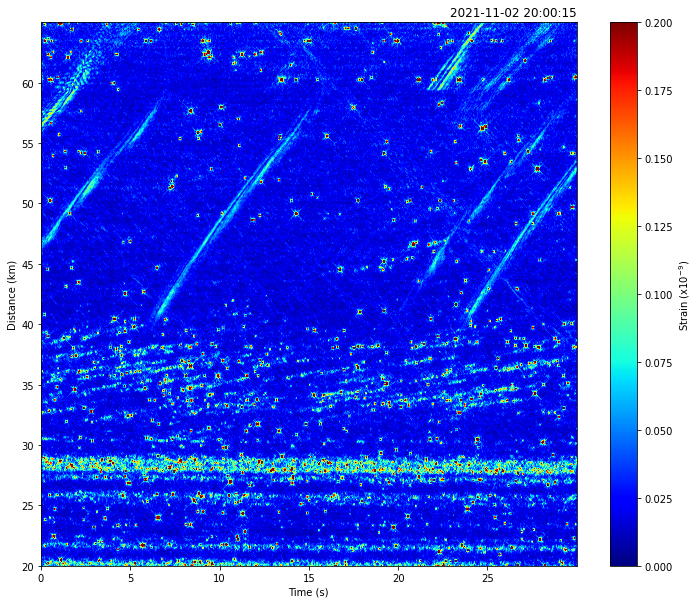

In [10]:
for fnb in range(2400,2401,1):
    #fnb in range(673,len(flist),1):
    #fnb = 673
    print(fnb,'/', len(flist))
    #logging.info('Processing file #%s in the loop %s', fnb, flist[fnb])
    
    # Load DAS data
    tr, tx, dist, fileBeginTimeUTC = load_DASdata(flist[fnb],fs,dx,selected_channels,scale_factor)
    
    # high-pass filter
    trf = sp.sosfiltfilt(sos_hpfilt, tr, axis=1)
    
    # FK filter
    # loop is taking 1.4s - not much to crunch there
    trf_fk = fk_filtering(trf,selected_channels,fs,cmin=1450,cmax=3000)
    
    # TX-plot of the FK filtered data, additionally band-pass filtered 
    trff = sp.sosfiltfilt(sos_bpfilt, trf_fk, axis=1)
    
    
    #start_time = time.time()
    plot_save_TX(trff,tx,dist,fs,selected_channels,fileBeginTimeUTC,plotsavefolder)
    #print("TX_plot", time.time() - start_time, "to run")
    
    # Save 2s-long FX-plot of the FK filtered data
    plot_save_FX_loop(trf_fk,dist,fs,fileBeginTimeUTC,plotsavefolder,win_s = 2,nfft = 4096)
    #print("FX_plot", time.time() - start_time, "to run")
    
    del tr, tx, dist, fileBeginTimeUTC, trf, trf_fk, trff